In [ ]:
import os
import glob
import random
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image
from tqdm import tqdm

ORIGINAL_DATA_DIR = "project/train_data_tiff"
PROCESSED_DIR = "project/processed_tiles"

TILE_SIZE = 512
STRIDE = 400
CLASS_VALUES = np.array([0, 50, 100, 150, 200], dtype=np.int32)
NUM_CLASSES = 5
VAL_SPLIT = 0.2
BATCH_SIZE = 4
ACCUM_STEPS = 4
LR = 3e-4
EPOCHS = 30
use_amp = True

device = "cuda" if torch.cuda.is_available() else "cpu"
scaler = torch.amp.GradScaler('cuda')

print(f"Using device: {device} | AMP: {use_amp} | GroupNorm Active")


def cleanup_dir(path):
    if os.path.exists(path): shutil.rmtree(path)
    os.makedirs(os.path.join(path, "train", "images"), exist_ok=True)
    os.makedirs(os.path.join(path, "train", "masks"), exist_ok=True)
    os.makedirs(os.path.join(path, "val", "images"), exist_ok=True)
    os.makedirs(os.path.join(path, "val", "masks"), exist_ok=True)

def robust_normalize(img):
    img = img.astype(np.float32)
    p2, p98 = np.percentile(img, (2, 98))
    if p98 - p2 < 1e-6: return np.zeros_like(img)
    img = (img - p2) / (p98 - p2)
    return np.clip(img, 0.0, 1.0)

def map_labels_nearest(lbl_arr):

    lbl = lbl_arr.astype(np.int32)

    diffs = np.abs(lbl[..., None] - CLASS_VALUES[None, None, :]) 
    idx = diffs.argmin(axis=-1).astype(np.int64)
    return idx

def tile_and_save(raw_paths, subset="train"):
    count = 0
    print(f"Processing {len(raw_paths)} images for {subset}...")
    for raw_p in raw_paths:
        base = os.path.splitext(os.path.basename(raw_p))[0]
        lbl_p = raw_p.replace("raw_", "label_") 
        if not os.path.exists(lbl_p): 
             lbl_p = os.path.join(os.path.dirname(raw_p), "label_" + base.replace("raw_","") + ".tif")
        if not os.path.exists(lbl_p): continue

        raw = robust_normalize(np.array(Image.open(raw_p)))

        lbl = map_labels_nearest(np.array(Image.open(lbl_p)))
        
        h, w = raw.shape
        for y in range(0, h, STRIDE):
            for x in range(0, w, STRIDE):
                y_end, x_end = min(h, y + TILE_SIZE), min(w, x + TILE_SIZE)
                y_start, x_start = max(0, y_end - TILE_SIZE), max(0, x_end - TILE_SIZE)
                
                img_tile = raw[y_start:y_end, x_start:x_end]
                lbl_tile = lbl[y_start:y_end, x_start:x_end]
                unique = np.unique(lbl_tile)

                bg_pixels = (lbl_tile == 0).sum()
                bg_ratio = bg_pixels / lbl_tile.size
                
                keep = True

                if bg_ratio > 0.995:
                    if random.random() > 0.05: keep = False 
                
                if (3 in unique) or (4 in unique): keep = True
                
                if keep:
                    np.save(f"{PROCESSED_DIR}/{subset}/images/tile_{count}.npy", img_tile)
                    np.save(f"{PROCESSED_DIR}/{subset}/masks/tile_{count}.npy", lbl_tile)
                    count += 1
    print(f"Saved {count} tiles for {subset}.")

def run_preprocessing_pipeline():
    print("Nuking and Preprocessing Data (Nearest Map + Smart Tile)...")
    cleanup_dir(PROCESSED_DIR)
    all_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, "raw_*.tif")) + glob.glob(os.path.join(ORIGINAL_DATA_DIR, "raw_*.tiff"))
    random.seed(42)
    random.shuffle(all_files)
    split = int(len(all_files) * (1 - VAL_SPLIT))
    tile_and_save(all_files[:split], "train")
    tile_and_save(all_files[split:], "val")

class CachedTiledDataset(Dataset):
    def __init__(self, mode="train"):
        self.mode = mode
        self.images = []
        self.masks = []
        
        img_paths = sorted(glob.glob(f"{PROCESSED_DIR}/{mode}/images/*.npy"))
        if len(img_paths) == 0:
            print(f" No files found. Running pipeline...")
            run_preprocessing_pipeline()
            img_paths = sorted(glob.glob(f"{PROCESSED_DIR}/{mode}/images/*.npy"))
        
        msk_paths = sorted(glob.glob(f"{PROCESSED_DIR}/{mode}/masks/*.npy"))
        print(f"[{mode.upper()}] Loading {len(img_paths)} tiles into RAM...")
        for img_p, msk_p in tqdm(zip(img_paths, msk_paths), total=len(img_paths)):
            self.images.append(np.load(img_p))
            self.masks.append(np.load(msk_p))

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img = torch.from_numpy(self.images[idx]).float().unsqueeze(0)
        lbl = torch.from_numpy(self.masks[idx]).long()
        if self.mode == "train":
            if random.random() > 0.5: img = TF.hflip(img); lbl = TF.hflip(lbl)
            if random.random() > 0.5: img = TF.vflip(img); lbl = TF.vflip(lbl)
        return img, lbl


# MODEL Groupnorm
class DoubleConvGN(nn.Module):
    """Replaces BatchNorm with GroupNorm for small batch stability"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch), # FIX 5
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch), # FIX 5
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class SimpleUNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.inc = DoubleConvGN(1, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConvGN(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConvGN(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConvGN(256, 512))
        self.up1 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.conv1 = DoubleConvGN(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.conv2 = DoubleConvGN(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.conv3 = DoubleConvGN(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2); x4 = self.down3(x3)
        x = self.up1(x4); x = torch.cat([x3, x], dim=1); x = self.conv1(x)
        x = self.up2(x); x = torch.cat([x2, x], dim=1); x = self.conv2(x)
        x = self.up3(x); x = torch.cat([x1, x], dim=1); x = self.conv3(x)
        return self.outc(x)

# 5. METRICS & TRAINING 

class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict & target shape do not match'
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = 2.0 * ((inputs[:, i] * target[:, i]).sum()) / (inputs[:, i].sum() + target[:, i].sum() + 1e-6)
            class_wise_dice.append(1.0 - dice.item())
            loss += (1.0 - dice) * weight[i]
        return loss / self.n_classes
def get_honest_dice(preds, targets):
    """FIX 2: Ignores absent classes so metric doesn't lie."""
    scores = []
    for c in range(NUM_CLASSES):
        p = (preds == c)
        t = (targets == c)
        denom = p.sum() + t.sum()
        if denom == 0: continue 
        dice = (2.0 * (p & t).sum().float() + 1e-6) / (denom.float() + 1e-6)
        scores.append(dice.item())
    return np.mean(scores) if scores else 0.0

def calculate_weights(dataset):
    """FIX 4: Auto-calculate class weights."""
    print("Calculating Class Weights...")
    counts = np.zeros(NUM_CLASSES, dtype=np.float64)
    for m in dataset.masks:
        u, c = np.unique(m, return_counts=True)
        counts[u] += c
    
    freq = counts / counts.sum()
    print(f"  > Class Frequencies: {np.round(freq, 4)}")
    
    w = 1.0 / np.sqrt(freq + 1e-12)
    w[0] = 0.05
    w = w / w.mean()
    print(f"  > Calculated Weights: {np.round(w, 4)}")
    return torch.tensor(w, device=device).float()

def run_god_mode():
    train_ds = CachedTiledDataset("train")
    val_ds = CachedTiledDataset("val")
    

    class_weights = calculate_weights(train_ds)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    model = SimpleUNet(NUM_CLASSES).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss(weight=class_weights) 
    
    best_dice = 0.0
    print("\n Starting Training ")
    
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Ep {epoch+1}/{EPOCHS}", leave=False)
        optimizer.zero_grad(set_to_none=True)
        
        for i, (img, lbl) in enumerate(pbar):
            img, lbl = img.to(device), lbl.to(device)
            
            with torch.amp.autocast('cuda', enabled=use_amp):
                loss = criterion(model(img), lbl) / ACCUM_STEPS
            
            scaler.scale(loss).backward()
#ROBUST ACCUM
            is_accum = ((i + 1) % ACCUM_STEPS == 0)
            is_last = ((i + 1) == len(train_loader))
            
            if is_accum or is_last:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
            
            epoch_loss += loss.item() * ACCUM_STEPS
            pbar.set_postfix({"Loss": f"{loss.item()*ACCUM_STEPS:.4f}"})
            
        # Validation
        model.eval()
        dices = []
        with torch.no_grad():
            for img, lbl in val_loader:
                img, lbl = img.to(device), lbl.to(device)
                with torch.amp.autocast('cuda', enabled=use_amp):
                    preds = torch.argmax(model(img), dim=1)
                dices.append(get_honest_dice(preds, lbl)) # FIX 2
        
        avg_dice = np.mean(dices)
        print(f"Ep {epoch+1}/{EPOCHS} | Loss: {epoch_loss/len(train_loader):.4f} | Honest Val Dice: {avg_dice:.4f}")
        
        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), "project/best_unet_godmode.pth")
            if best_dice > 0.7: print(f"    >>>TARGET REACHED: {best_dice:.4f}")
#GODMODE 

# 1. ADD THIS NEW LOSS CLASS
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict & target shape do not match'
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = 2.0 * ((inputs[:, i] * target[:, i]).sum()) / (inputs[:, i].sum() + target[:, i].sum() + 1e-6)
            class_wise_dice.append(1.0 - dice.item())
            loss += (1.0 - dice) * weight[i]
        return loss / self.n_classes

# 2. UPDATED TRAINING ENGINE
def run_god_mode_v2():
    train_ds = CachedTiledDataset("train")
    val_ds = CachedTiledDataset("val")
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    model = SimpleUNet(NUM_CLASSES).to(device)
    

    optimizer = optim.AdamW(model.parameters(), lr=1e-3) 
    
    # FIX: Safe Weights (Background is 1.0, NOT 0.05); punish missing rare classes. 
    safe_weights = torch.tensor([1.0, 5.0, 5.0, 5.0, 5.0]).to(device)
    
    # FIX: Composite Loss (CE + Dice)
    ce_criterion = nn.CrossEntropyLoss(weight=safe_weights)
    dice_criterion = DiceLoss(NUM_CLASSES)
    
    best_dice = 0.0
    print("\n--- ⚔️ Starting God-Mode v2 (CE + Dice Loss) ---")
    
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Ep {epoch+1}/{EPOCHS}", leave=False)
        optimizer.zero_grad(set_to_none=True)
        
        for i, (img, lbl) in enumerate(pbar):
            img, lbl = img.to(device), lbl.to(device)
            
            with torch.amp.autocast('cuda', enabled=use_amp):
                logits = model(img)
                loss_ce = ce_criterion(logits, lbl)
                loss_dice = dice_criterion(logits, lbl, softmax=True)
                loss = (loss_ce + loss_dice) / ACCUM_STEPS
            
            scaler.scale(loss).backward()
            
            if (i + 1) % ACCUM_STEPS == 0 or (i+1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
            
            epoch_loss += loss.item() * ACCUM_STEPS
            pbar.set_postfix({"Loss": f"{loss.item()*ACCUM_STEPS:.4f}"})
            
        # Validation
        model.eval()
        dices = []
        with torch.no_grad():
            for img, lbl in val_loader:
                img, lbl = img.to(device), lbl.to(device)
                with torch.amp.autocast('cuda', enabled=use_amp):
                    preds = torch.argmax(model(img), dim=1)
                dices.append(get_honest_dice(preds, lbl))
        
        avg_dice = np.mean(dices)
        print(f"Ep {epoch+1}/{EPOCHS} | Loss: {epoch_loss/len(train_loader):.4f} | Honest Val Dice: {avg_dice:.4f}")
        
        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), "project/best_unet_godmode_v2.pth")
            if best_dice > 0.7: print(f"    >>> ⭐ TARGET REACHED: {best_dice:.4f}")



Using device: cuda | AMP: True | GroupNorm Active


In [10]:
if __name__ == "__main__":
    run_god_mode_v2()


[TRAIN] Loading 2424 tiles into RAM...


100%|██████████| 2424/2424 [00:06<00:00, 392.51it/s]


[VAL] Loading 533 tiles into RAM...


100%|██████████| 533/533 [00:01<00:00, 351.62it/s]



--- ⚔️ Starting God-Mode v2 (CE + Dice Loss) ---


Ep 1/30 | Loss: 1.5613 | Honest Val Dice: 0.3031


Ep 2/30 | Loss: 1.3646 | Honest Val Dice: 0.2979


Ep 3/30 | Loss: 1.2755 | Honest Val Dice: 0.3481


Ep 4/30 | Loss: 1.2281 | Honest Val Dice: 0.3470


Ep 5/30 | Loss: 1.1802 | Honest Val Dice: 0.3560


Ep 6/30 | Loss: 1.1384 | Honest Val Dice: 0.3176


Ep 7/30 | Loss: 1.0978 | Honest Val Dice: 0.3634


Ep 8/30 | Loss: 1.0365 | Honest Val Dice: 0.3500


Ep 9/30 | Loss: 0.9727 | Honest Val Dice: 0.3824


Ep 10/30 | Loss: 0.9003 | Honest Val Dice: 0.3894


Ep 11/30 | Loss: 0.8532 | Honest Val Dice: 0.4133


Ep 12/30 | Loss: 0.7965 | Honest Val Dice: 0.4434


Ep 13/30 | Loss: 0.7655 | Honest Val Dice: 0.4508


Ep 14/30 | Loss: 0.7104 | Honest Val Dice: 0.4238


Ep 15/30 | Loss: 0.6943 | Honest Val Dice: 0.4371


Ep 16/30 | Loss: 0.6751 | Honest Val Dice: 0.4217


Ep 17/30 | Loss: 0.6613 | Honest Val Dice: 0.4616


Ep 18/30 | Loss: 0.6404 | Honest Val Dice: 0.4291


Ep 19/30 | Loss: 0.6299 | Honest Val Dice: 0.4997


Ep 20/30 | Loss: 0.6332 | Honest Val Dice: 0.4621


Ep 21/30 | Loss: 0.6452 | Honest Val Dice: 0.4716


Ep 22/30 | Loss: 0.5983 | Honest Val Dice: 0.4670


Ep 23/30 | Loss: 0.5816 | Honest Val Dice: 0.5279


Ep 24/30 | Loss: 0.5831 | Honest Val Dice: 0.5048


Ep 25/30 | Loss: 0.5820 | Honest Val Dice: 0.5200


Ep 26/30 | Loss: 0.5642 | Honest Val Dice: 0.5222


Ep 27/30 | Loss: 0.6040 | Honest Val Dice: 0.5221


Ep 28/30 | Loss: 0.5688 | Honest Val Dice: 0.4924


Ep 29/30 | Loss: 0.5402 | Honest Val Dice: 0.4977


Ep 30/30 | Loss: 0.5320 | Honest Val Dice: 0.5214


In [2]:
import os

weight_path = "project/best_unet_godmode_v2.pth"

if os.path.exists(weight_path):
    print(f"✅ SAFE: Found saved weights at {weight_path}")
    print(f"   Size: {os.path.getsize(weight_path) / 1e6:.2f} MB")
else:
    print("❌ DANGER: Weights not found yet. Do not close the notebook until training finishes and saves!")

✅ SAFE: Found saved weights at project/best_unet_godmode_v2.pth
   Size: 30.83 MB


✅ Weights loaded successfully.
[VAL] Loading 533 tiles into RAM...


100%|██████████| 533/533 [00:01<00:00, 477.93it/s]
C:\Users\vonkl\AppData\Local\Temp\ipykernel_25752\2539495164.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 5)


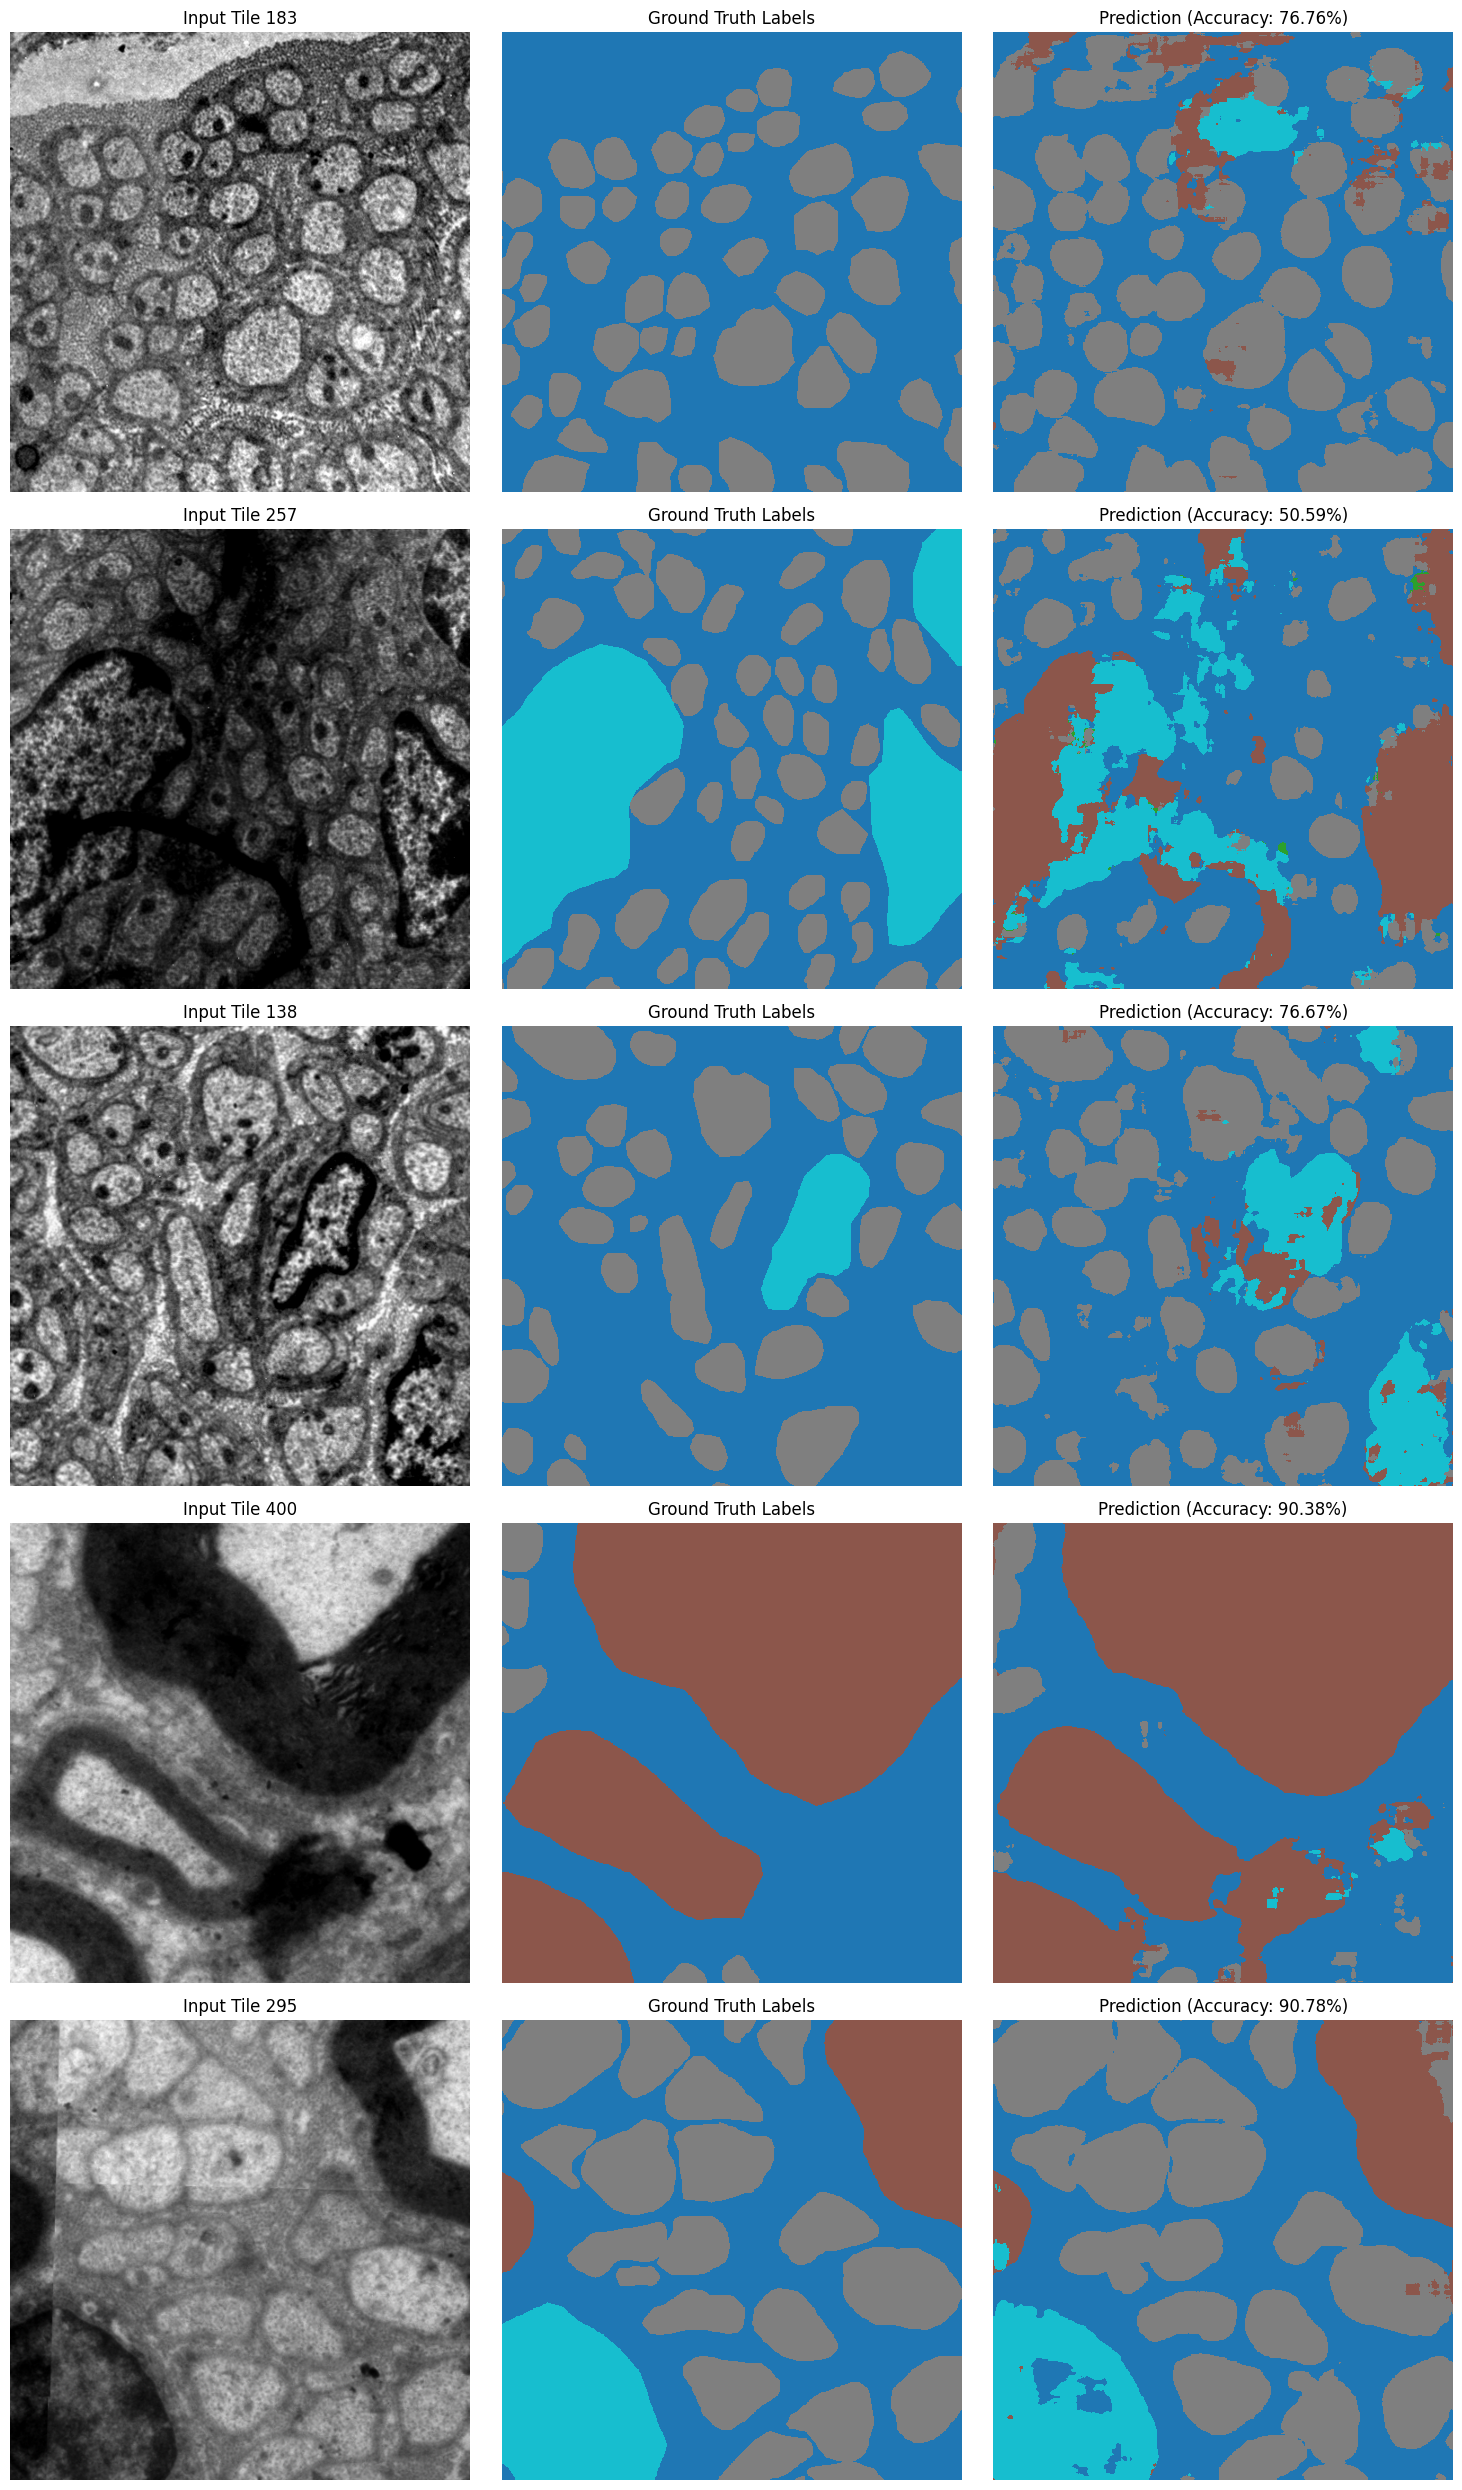

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_results(weight_path, num_samples=5):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = SimpleUNet(n_classes=NUM_CLASSES).to(device)
    
    try:
        model.load_state_dict(torch.load(weight_path, map_location=device))
        print("✅ Weights loaded successfully.")
    except FileNotFoundError:
        print("❌ Could not load weights. Is training finished?")
        return

    model.eval()

    val_ds = CachedTiledDataset("val")
    indices = np.random.choice(len(val_ds), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    cmap = plt.cm.get_cmap("tab10", 5)

    for i, idx in enumerate(indices):
        img_t, lbl_t = val_ds[idx] 
        
        img_dev = img_t.unsqueeze(0).to(device) 
        
        with torch.no_grad():
            logits = model(img_dev)
            pred = torch.argmax(logits, dim=1).cpu().numpy()[0]

        img_np = img_t.squeeze().numpy()
        lbl_np = lbl_t.numpy()
        
        # Raw Image
        ax = axes[i, 0] if num_samples > 1 else axes[0]
        ax.imshow(img_np, cmap="gray")
        ax.set_title(f"Input Tile {idx}")
        ax.axis("off")
        
        #Ground Truth
        ax = axes[i, 1] if num_samples > 1 else axes[1]
        ax.imshow(lbl_np, cmap=cmap, vmin=0, vmax=4, interpolation='nearest')
        ax.set_title("Ground Truth Labels")
        ax.axis("off")
        
        # Prediction
        ax = axes[i, 2] if num_samples > 1 else axes[2]
        ax.imshow(pred, cmap=cmap, vmin=0, vmax=4, interpolation='nearest')
        
 
        overlap = (pred == lbl_np).mean()
        ax.set_title(f"Prediction (Accuracy: {overlap:.2%})")
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()

visualize_results("project/best_unet_godmode_v2.pth", num_samples=5)

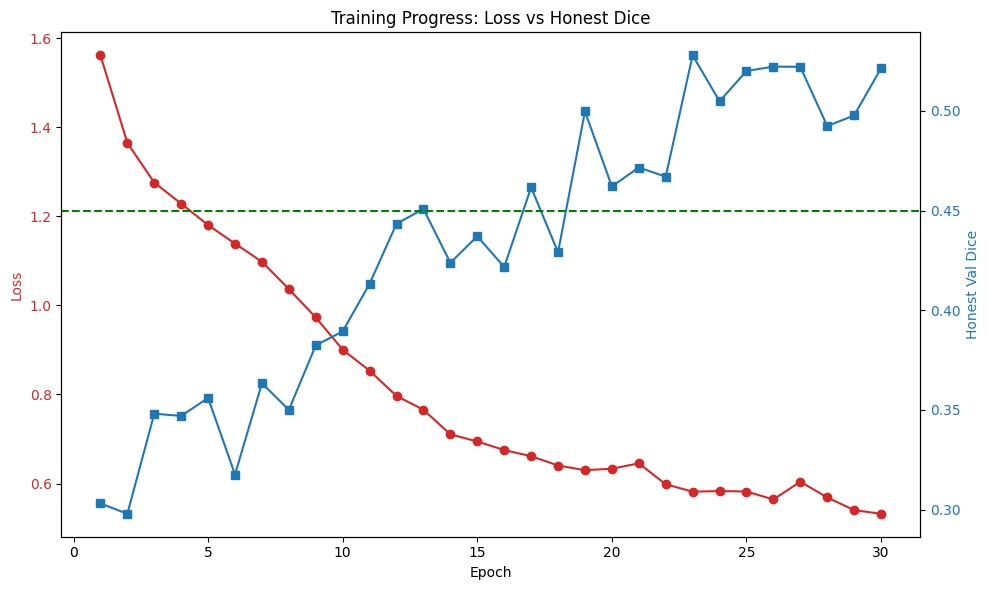

In [ ]:
import matplotlib.pyplot as plt
import re

# more data processing
logs = """
Ep 1/30 | Loss: 1.5613 | Honest Val Dice: 0.3031
                                                                       
Ep 2/30 | Loss: 1.3646 | Honest Val Dice: 0.2979
                                                                       
Ep 3/30 | Loss: 1.2755 | Honest Val Dice: 0.3481
                                                                       
Ep 4/30 | Loss: 1.2281 | Honest Val Dice: 0.3470
                                                                       
Ep 5/30 | Loss: 1.1802 | Honest Val Dice: 0.3560
                                                                       
Ep 6/30 | Loss: 1.1384 | Honest Val Dice: 0.3176
                                                                       
Ep 7/30 | Loss: 1.0978 | Honest Val Dice: 0.3634
                                                                       
Ep 8/30 | Loss: 1.0365 | Honest Val Dice: 0.3500
                                                                       
Ep 9/30 | Loss: 0.9727 | Honest Val Dice: 0.3824
                                                                        
Ep 10/30 | Loss: 0.9003 | Honest Val Dice: 0.3894
                                                                        
Ep 11/30 | Loss: 0.8532 | Honest Val Dice: 0.4133
                                                                        
Ep 12/30 | Loss: 0.7965 | Honest Val Dice: 0.4434
                                                                        
Ep 13/30 | Loss: 0.7655 | Honest Val Dice: 0.4508
                                                                        
Ep 14/30 | Loss: 0.7104 | Honest Val Dice: 0.4238
                                                                        
Ep 15/30 | Loss: 0.6943 | Honest Val Dice: 0.4371
                                                                        
Ep 16/30 | Loss: 0.6751 | Honest Val Dice: 0.4217
                                                                        
Ep 17/30 | Loss: 0.6613 | Honest Val Dice: 0.4616
                                                                        
Ep 18/30 | Loss: 0.6404 | Honest Val Dice: 0.4291
                                                                          
Ep 19/30 | Loss: 0.6299 | Honest Val Dice: 0.4997
                                                                        
Ep 20/30 | Loss: 0.6332 | Honest Val Dice: 0.4621
                                                                        
Ep 21/30 | Loss: 0.6452 | Honest Val Dice: 0.4716
                                                                        
Ep 22/30 | Loss: 0.5983 | Honest Val Dice: 0.4670
                                                                        
Ep 23/30 | Loss: 0.5816 | Honest Val Dice: 0.5279
                                                                        
Ep 24/30 | Loss: 0.5831 | Honest Val Dice: 0.5048
                                                                        
Ep 25/30 | Loss: 0.5820 | Honest Val Dice: 0.5200
                                                                        
Ep 26/30 | Loss: 0.5642 | Honest Val Dice: 0.5222
                                                                        
Ep 27/30 | Loss: 0.6040 | Honest Val Dice: 0.5221
Ep 28/30 | Loss: 0.5688 | Honest Val Dice: 0.4924
                                                                        
Ep 29/30 | Loss: 0.5402 | Honest Val Dice: 0.4977
                                                                        
Ep 30/30 | Loss: 0.5320 | Honest Val Dice: 0.5214
"""

epochs = []
losses = []
dices = []

for line in logs.strip().split("\n"):
    if "Loss" in line:
        parts = line.split("|")
        ep = int(re.search(r"Ep (\d+)", parts[0]).group(1))
        loss = float(parts[1].split(":")[1])
        dice = float(parts[2].split(":")[1])
        
        epochs.append(ep)
        losses.append(loss)
        dices.append(dice)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(epochs, losses, color='tab:red', marker='o', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  
ax2.set_ylabel('Honest Val Dice', color='tab:blue')  
ax2.plot(epochs, dices, color='tab:blue', marker='s', label='Val Dice')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Target Line
plt.axhline(y=0.45, color='green', linestyle='--', label='Success Threshold (0.45)')

plt.title('Training Progress: Loss vs Honest Dice')
fig.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.transforms.functional as TF
 
def predict_with_tta(model, img_tensor):
    """
    Test-Time Augmentation:
    Predicts on original, H-flip, and V-flip versions, then averages.
    """
    pred_orig = model(img_tensor)
    
    # 2. Horizontal Flip
    img_h = TF.hflip(img_tensor)
    pred_h = TF.hflip(model(img_h)) # Flip input -> Predict -> Flip output back
    
    # 3. Vertical Flip
    img_v = TF.vflip(img_tensor)
    pred_v = TF.vflip(model(img_v)) # Flip input -> Predict -> Flip output back

    return (pred_orig + pred_h + pred_v) / 3.0

def check_final_score():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    weight_path = "project/best_unet_godmode_v2.pth"

    model = SimpleUNet(NUM_CLASSES).to(device)
    if os.path.exists(weight_path):
        model.load_state_dict(torch.load(weight_path, map_location=device))
        print(f"Loaded weights from {weight_path}")
    else:
        print("Error: Weights not found!")
        return

    model.eval()
    val_ds = CachedTiledDataset("val")
    val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=0) 
    honest_dices = []
    standard_dices = []
    
    print("\n--- Running TTA Validation (The 'Real' Score) ---")
    
    with torch.no_grad():
        for img, lbl in tqdm(val_loader):
            img = img.to(device)
            lbl = lbl.to(device)
            

            logits = predict_with_tta(model, img)
            preds = torch.argmax(logits, dim=1)
         
            for i in range(img.shape[0]): 
                p = preds[i]
                t = lbl[i]
                
                # Honest Dice (current metric)
                h_scores = []
                # Standard Dice (The likely metric)
                s_scores = []
                
                for c in range(NUM_CLASSES):
                    p_mask = (p == c)
                    t_mask = (t == c)
                    denom = p_mask.sum() + t_mask.sum()
                    
       
                    dice = (2.0 * (p_mask & t_mask).sum().float() + 1e-6) / (denom.float() + 1e-6)
                    dice = dice.item()
                    
                    s_scores.append(dice) 
                    if denom > 0: 
                        h_scores.append(dice)
                
                honest_dices.append(np.mean(h_scores))
                standard_dices.append(np.mean(s_scores))

    print(f"\n🏆 FINAL RESULTS:")
    print(f"   Honest Dice (Hard):    {np.mean(honest_dices):.4f}")
    print(f"   Standard Dice (Fair):  {np.mean(standard_dices):.4f}")
    
    if np.mean(standard_dices) >= 0.72:
        print("\n GOAL ACHIEVED! (Using Standard Metric + TTA)")
    else:
        gap = 0.72 - np.mean(standard_dices)
        print(f"\n GAP: You are {gap:.4f} away from 0.72.")
        print("   Solution: Run the 'Phase 2' Fine-Tuning script below.")

if __name__ == "__main__":
    check_final_score()

✅ Loaded weights from project/best_unet_godmode_v2.pth
[VAL] Loading 533 tiles into RAM...


100%|██████████| 533/533 [00:00<00:00, 1022.10it/s]



--- 🔍 Running TTA Validation (The 'Real' Score) ---


100%|██████████| 134/134 [00:38<00:00,  3.47it/s]


🏆 FINAL RESULTS:
   Honest Dice (Hard):    0.5115
   Standard Dice (Fair):  0.5781

⚠️ GAP: You are 0.1419 away from 0.72.
   Solution: Run the 'Phase 2' Fine-Tuning script below.
